In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import os
import numpy as np

### Exploración de BD

In [8]:

segmentation_file = '../ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00000-000/BraTS-GLI-00000-000-seg.nii.gz'
t1gd_file = '../ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t1n.nii.gz'
t2_file = '../ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t2f.nii.gz'
t2_flair_file = '../ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t2w.nii.gz'

In [10]:
total_train = os.listdir('../ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/')
print("Total training patients: ", len(total_train))
#total_val = os.listdir('../ASNR-MICCAI-BraTS2023-GLI-Challenge-ValidationData/')
#print("Total validation patients: ", len(total_val))
seg_img = nib.load(segmentation_file)
seg_img = nib.load(segmentation_file)
t1gd_img = nib.load(t1gd_file)
t2_img = nib.load(t2_file)
t2_flair_img = nib.load(t2_flair_file)

seg_data = seg_img.get_fdata()
t1gd_data = t1gd_img.get_fdata()
t2_data = t2_img.get_fdata()
t2_flair_data = t2_flair_img.get_fdata()
print("In general each .nii file has the following shape: ", seg_data.shape)
print("In total in axial view we have: ", seg_data.shape[2]*len(total_train), "slices")
print("In total in sagittal view we have: ", seg_data.shape[0]*len(total_train), "slices")
print("In total in coronal view we have: ", seg_data.shape[1]*len(total_train), "slices")

Total training patients:  1251
In general each .nii file has the following shape:  (240, 240, 155)
In total in axial view we have:  193905 slices
In total in sagittal view we have:  300240 slices
In total in coronal view we have:  300240 slices


[0. 1. 2. 3.]


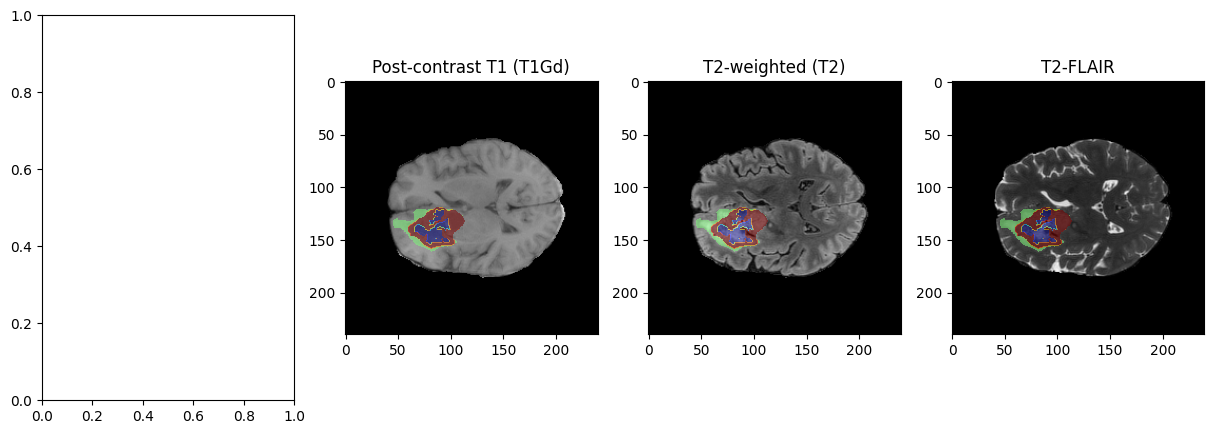

In [12]:
##########################################################################33
# PLOTTING
##########################################################################33



slice_index = seg_data.shape[2] // 2

mask = np.isin(seg_data[:, :, slice_index], [1, 2, 3])

fig, axes = plt.subplots(1, 4, figsize=(15, 5))



axes[1].imshow(t1gd_data[:, :, t1gd_data.shape[2] // 2], cmap='gray')
axes[1].imshow(np.where(mask, seg_data[:, :, slice_index], np.nan), cmap='jet', alpha=0.5)
axes[1].set_title('Post-contrast T1 (T1Gd)')


axes[2].imshow(t2_data[:, :, t2_data.shape[2] // 2], cmap='gray')
axes[2].imshow(np.where(mask, seg_data[:, :, slice_index], np.nan), cmap='jet', alpha=0.5)
axes[2].set_title('T2-weighted (T2)')

axes[3].imshow(t2_flair_data[:, :, t2_flair_data.shape[2] // 2], cmap='gray')
axes[3].imshow(np.where(mask, seg_data[:, :, slice_index], np.nan), cmap='jet', alpha=0.5)
print(np.unique(seg_data[:, :, slice_index]))
axes[3].set_title('T2-FLAIR')

plt.show()


In [3]:
import os
import numpy as np
import shutil
import random
import nibabel as nib
from PIL import Image
from tqdm import tqdm
from skimage import exposure
def znorm_rescale(img):
    """Applies Z-score normalization and rescaling to a MRI image."""

    # Z-score norm
    movingNan=np.copy(img)
    movingNan[movingNan==0]=np.nan
    movingMean=np.nanmean(movingNan)
    movingSTD=np.nanstd(movingNan)
    moving=(img-movingMean)/movingSTD
    b=255/(1-(moving.max()/moving.min()))
    a=-b/moving.min()
    movingNorm=np.copy(moving)
    movingNorm=np.round((movingNorm*a)+b,2)

    # Rescaling
    p2, p98 = np.percentile(movingNorm, (1, 99)) # These parameters may not be optimal, further testing could be done
    moving_rescale = exposure.rescale_intensity(movingNorm, in_range=(p2, p98))

    return moving_rescale

def extract_and_save_axial_slices(input_file, output_directory, patient_folder):
    # Load the NIfTI file
    img = nib.load(input_file)

    # Get the image data as a 3D numpy array
    img_data = img.get_fdata()

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Iterate through axial slices and save each as a separate JPEG image
    for slice_idx in tqdm(range(img_data.shape[2]), desc=f"Processing {patient_folder}"):
        axial_slice = img_data[:, :, slice_idx]
        if 69 <= slice_idx <= 99:
            if "seg" in input_file:
                np.save(os.path.join(output_directory, f"{patient_folder}_{slice_idx+1}.npy"), axial_slice)
            else:
                # Apply Z-score normalization and rescaling
                #axial_slice = znorm_rescale(axial_slice)
                # save as .npy
                np.save(os.path.join(output_directory, f"{patient_folder}_{slice_idx+1}.npy"), axial_slice)

def process_data(root_folder, output_folder, random_seed=42):
    # Set the random seed for reproducibility
    random.seed(random_seed)

    # List all patient folders in the root folder
    patient_folders = [f for f in os.listdir(root_folder) if f.startswith('BraTS-GLI-')]
    
    # Randomly shuffle patient folders
    random.shuffle(patient_folders)

    # Define the output folder for axial slices
    axial_slices_folder = os.path.join(output_folder, 'BraTS2023_AxialSlices')

    # Create output folder if it doesn't exist
    os.makedirs(axial_slices_folder, exist_ok=True)

    # Determine the split index for 80/20 split
    split_index = int(0.8 * len(patient_folders))

    # Iterate through patient folders and extract/save axial slices
    for idx, patient_folder in enumerate(patient_folders):
        # Identify the files to process
        t1c_file = os.path.join(root_folder, patient_folder, f"{patient_folder}-t1c.nii.gz")
        seg_file = os.path.join(root_folder, patient_folder, f"{patient_folder}-seg.nii.gz")

        # Choose the appropriate output folders based on the split index
        data_folder = os.path.join(axial_slices_folder, 'Train', 'Data') if idx < split_index else os.path.join(axial_slices_folder, 'Test', 'Data')
        mask_folder = os.path.join(axial_slices_folder, 'Train', 'Mask') if idx < split_index else os.path.join(axial_slices_folder, 'Test', 'Mask')

        # Extract and save axial slices for 'Data' folder
        extract_and_save_axial_slices(t1c_file, data_folder, patient_folder)

        # Extract and save axial slices for 'Mask' folder
        extract_and_save_axial_slices(seg_file, mask_folder, patient_folder)

    print("Processing complete.")

if __name__ == "__main__":
    # Specify the root folder containing patient folders
    root_folder = "/home/srodriguez47/ddpm/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData"

    # Specify the output folder for the axial slices
    output_folder = "/home/srodriguez47/ddpm/BraTS2023_StructuredDataV3.0-t1c"

    # Set the random seed for reproducibility
    random_seed = 42

    # Process the data and create the desired folder structure for axial slices
    process_data(root_folder, output_folder, random_seed)


Processing BraTS-GLI-00022-000: 100%|██████████| 155/155 [00:00<00:00, 8566.12it/s]

Processing complete.


In [15]:
from PIL import Image
import numpy as np
lista_train = "../BraTS2023_StructuredDataV2-t2w/BraTS2023_AxialSlices/Train/Data"
lista_train_seg = "../BraTS2023_StructuredDataV2-t2w/BraTS2023_AxialSlices/Train/Mask"
lista_test = "../BraTS2023_StructuredDataV2-t2w/BraTS2023_AxialSlices/Test/Data"
lista_test_seg = "../BraTS2023_StructuredDataV2-t2w/BraTS2023_AxialSlices/Test/Mask"

lista_total = os.listdir(lista_train)
print("Total training slices: ", len(lista_total))
lista_total = os.listdir(lista_test)
print("Total test slices: ", len(lista_total))

black_images = []

for img_name in os.listdir(lista_train):
    img_path = os.path.join(lista_train, img_name)
    img_path_seg = os.path.join(lista_train_seg, img_name)
    img = Image.open(img_path)
    black_pixel_count = 0
    black_pixel_count = np.sum(np.all(np.array(img) == 0, axis=1))
    if black_pixel_count > 100:
    #if not np.any(np.array(img)):    
        black_images.append(img_name)
        os.remove(img_path)
        os.remove(img_path_seg)
print("Total black images in training: ", len(black_images))
print("Total training slices after removing black images: ", len(os.listdir(lista_train)))
black_images_test = []
for img_name in os.listdir(lista_test):
    img_path = os.path.join(lista_test, img_name)
    img_path_seg = os.path.join(lista_test_seg, img_name)
    img = Image.open(img_path)
    black_pixel_count = 0
    black_pixel_count = np.sum(np.all(np.array(img) == 0, axis=1))
    if black_pixel_count > 100:
    #if not np.any(np.array(img)):
        black_images_test.append(img_name)
        os.remove(img_path)
        os.remove(img_path_seg)

print("Total black images in test: ", len(black_images_test))
print("Total test slices after removing black images: ", len(os.listdir(lista_test)))


Total training slices:  155000
Total test slices:  38905
Total black images in training:  121279
Total training slices after removing black images:  33721
Total black images in test:  29957
Total test slices after removing black images:  8948


In [ ]:
assert len(os.listdir(lista_train)) == len(os.listdir(lista_train_seg))
assert len(os.listdir(lista_test)) == len(os.listdir(lista_test_seg))

In [13]:
import numpy as np
imgexample = "/media/user_home0/srodriguez47/ddpm/BraTS2023_StructuredDataV2/BraTS2023_AxialSlices/Test/Data/BraTS-GLI-00016-000-60.jpg"
imgexample2 = "/media/user_home0/srodriguez47/ddpm/BraTS2023_StructuredDataV2/BraTS2023_AxialSlices/Test/Data/BraTS-GLI-00016-000-1.jpg"

img = Image.open(imgexample)
black_pixel_count = 0
black_pixel_count = np.sum(np.all(np.array(img) == 0, axis=1))
print(black_pixel_count)
print(np.shape(img))


96
(240, 240)


## Set union

In [6]:
v2t1c = os.listdir("../BraTS2023_StructuredDataV2-t1c/BraTS2023_AxialSlices/Train/Data")
v2t1c_test = os.listdir("../BraTS2023_StructuredDataV2-t1c/BraTS2023_AxialSlices/Test/Data")
v2t1n = os.listdir("../BraTS2023_StructuredDataV2-t1n/BraTS2023_AxialSlices/Train/Data")
v2t1n_test = os.listdir("../BraTS2023_StructuredDataV2-t1n/BraTS2023_AxialSlices/Test/Data")
v2t2f = os.listdir("../BraTS2023_StructuredDataV2-t2f/BraTS2023_AxialSlices/Train/Data")
v2t2f_test = os.listdir("../BraTS2023_StructuredDataV2-t2f/BraTS2023_AxialSlices/Test/Data")
v2t2w = os.listdir("../BraTS2023_StructuredDataV2-t2w/BraTS2023_AxialSlices/Train/Data")
v2t2w_test = os.listdir("../BraTS2023_StructuredDataV2-t2w/BraTS2023_AxialSlices/Test/Data")

In [23]:
common_train_images = set(v2t1c).intersection(v2t1n).intersection(v2t2f).intersection(v2t2w)
common_test_images = set(v2t1c_test).intersection(v2t1n_test).intersection(v2t2f_test).intersection(v2t2w_test)
input_folders_train = ["../BraTS2023_StructuredDataV2-t1c/BraTS2023_AxialSlices/Train/Data",
                "../BraTS2023_StructuredDataV2-t1c/BraTS2023_AxialSlices/Train/Mask",
                 "../BraTS2023_StructuredDataV2-t1n/BraTS2023_AxialSlices/Train/Data",
                    "../BraTS2023_StructuredDataV2-t1n/BraTS2023_AxialSlices/Train/Mask", 
                 "../BraTS2023_StructuredDataV2-t2f/BraTS2023_AxialSlices/Train/Data", 
                    "../BraTS2023_StructuredDataV2-t2f/BraTS2023_AxialSlices/Train/Mask",
                 "../BraTS2023_StructuredDataV2-t2w/BraTS2023_AxialSlices/Train/Data",
                    "../BraTS2023_StructuredDataV2-t2w/BraTS2023_AxialSlices/Train/Mask"]

output_folder_train = ["../BraTS2023_StructuredDataV2.0-t1c/BraTS2023_AxialSlices/Train/Data",
                "../BraTS2023_StructuredDataV2.0-t1c/BraTS2023_AxialSlices/Train/Mask",
                 "../BraTS2023_StructuredDataV2.0-t1n/BraTS2023_AxialSlices/Train/Data",
                    "../BraTS2023_StructuredDataV2.0-t1n/BraTS2023_AxialSlices/Train/Mask", 
                 "../BraTS2023_StructuredDataV2.0-t2f/BraTS2023_AxialSlices/Train/Data", 
                    "../BraTS2023_StructuredDataV2.0-t2f/BraTS2023_AxialSlices/Train/Mask",
                 "../BraTS2023_StructuredDataV2.0-t2w/BraTS2023_AxialSlices/Train/Data",
                    "../BraTS2023_StructuredDataV2.0-t2w/BraTS2023_AxialSlices/Train/Mask"]

input_folders_test = ["../BraTS2023_StructuredDataV2-t1c/BraTS2023_AxialSlices/Test/Data",
                "../BraTS2023_StructuredDataV2-t1c/BraTS2023_AxialSlices/Test/Mask",
                 "../BraTS2023_StructuredDataV2-t1n/BraTS2023_AxialSlices/Test/Data",
                    "../BraTS2023_StructuredDataV2-t1n/BraTS2023_AxialSlices/Test/Mask", 
                 "../BraTS2023_StructuredDataV2-t2f/BraTS2023_AxialSlices/Test/Data", 
                    "../BraTS2023_StructuredDataV2-t2f/BraTS2023_AxialSlices/Test/Mask",
                 "../BraTS2023_StructuredDataV2-t2w/BraTS2023_AxialSlices/Test/Data",
                    "../BraTS2023_StructuredDataV2-t2w/BraTS2023_AxialSlices/Test/Mask"]

output_folder_test = ["../BraTS2023_StructuredDataV2.0-t1c/BraTS2023_AxialSlices/Test/Data",
                "../BraTS2023_StructuredDataV2.0-t1c/BraTS2023_AxialSlices/Test/Mask",
                 "../BraTS2023_StructuredDataV2.0-t1n/BraTS2023_AxialSlices/Test/Data",
                    "../BraTS2023_StructuredDataV2.0-t1n/BraTS2023_AxialSlices/Test/Mask", 
                 "../BraTS2023_StructuredDataV2.0-t2f/BraTS2023_AxialSlices/Test/Data", 
                    "../BraTS2023_StructuredDataV2.0-t2f/BraTS2023_AxialSlices/Test/Mask",
                 "../BraTS2023_StructuredDataV2.0-t2w/BraTS2023_AxialSlices/Test/Data",
                    "../BraTS2023_StructuredDataV2.0-t2w/BraTS2023_AxialSlices/Test/Mask"]
def create_new_db_with_common_images(common_images, output_folder, input_folders):
    for img  in common_images:
        for input_folder in range(len(input_folders)):
            img_path = os.path.join(input_folders[input_folder], img)
            output_path = os.path.join(output_folder[input_folder], img)
            shutil.copy(img_path, output_path)
    print("Done")

def create_new_folder_directories(output_folder):
    for folder in output_folder:
        os.makedirs(folder, exist_ok=True)

In [25]:
create_new_db_with_common_images(common_test_images, output_folder_test, input_folders_test)

Done


In [28]:
for dir in output_folder_train:
    print(dir)
    print(len(os.listdir(dir)))
for dir in output_folder_test:
    print(dir)
    print(len(os.listdir(dir)))

../BraTS2023_StructuredDataV2.0-t1c/BraTS2023_AxialSlices/Train/Data
33331
../BraTS2023_StructuredDataV2.0-t1c/BraTS2023_AxialSlices/Train/Mask
33331
../BraTS2023_StructuredDataV2.0-t1n/BraTS2023_AxialSlices/Train/Data
33331
../BraTS2023_StructuredDataV2.0-t1n/BraTS2023_AxialSlices/Train/Mask
33331
../BraTS2023_StructuredDataV2.0-t2f/BraTS2023_AxialSlices/Train/Data
33331
../BraTS2023_StructuredDataV2.0-t2f/BraTS2023_AxialSlices/Train/Mask
33331
../BraTS2023_StructuredDataV2.0-t2w/BraTS2023_AxialSlices/Train/Data
33331
../BraTS2023_StructuredDataV2.0-t2w/BraTS2023_AxialSlices/Train/Mask
33331
../BraTS2023_StructuredDataV2.0-t1c/BraTS2023_AxialSlices/Test/Data
8908
../BraTS2023_StructuredDataV2.0-t1c/BraTS2023_AxialSlices/Test/Mask
8908
../BraTS2023_StructuredDataV2.0-t1n/BraTS2023_AxialSlices/Test/Data
8908
../BraTS2023_StructuredDataV2.0-t1n/BraTS2023_AxialSlices/Test/Mask
8908
../BraTS2023_StructuredDataV2.0-t2f/BraTS2023_AxialSlices/Test/Data
8908
../BraTS2023_StructuredDataV2.0-t2f